In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import os
import sys

In [3]:
def canny_edge_detector(img):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    v_channel=  hsv[:,:,2]
    #_,s_channel=cv2.threshold(s_channel, 120, 255, cv2.THRESH_BINARY_INV)
    _,v_channel=cv2.threshold(v_channel,180, 255, cv2.THRESH_BINARY_INV)
    edged1=cv2.Canny(s_channel,50,150)
    edged2=cv2.Canny(v_channel,50,150)
    edged=edged1 | edged2
    print(edged)
    return edged

[[255   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0 255 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [255   0   0 ...   0   0 255]]


Text(0.5, 1.0, 'canny_edge_detector')

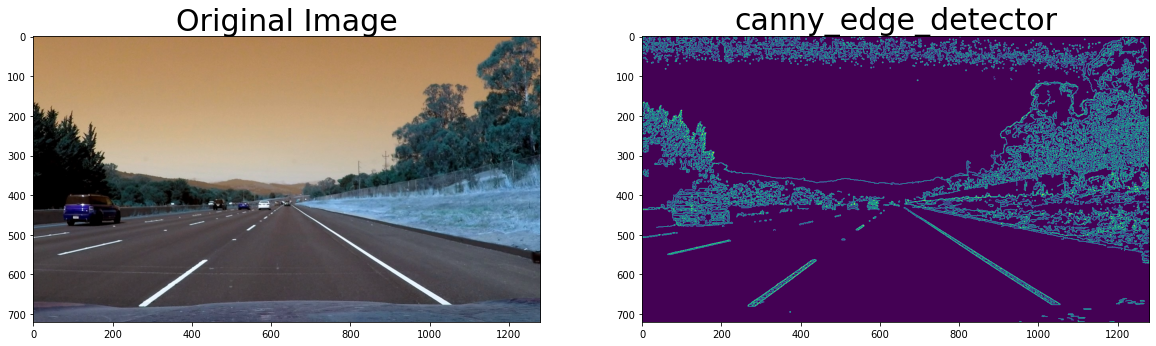

In [4]:
img = cv2.imread('test.jpg')
dst = canny_edge_detector(img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('canny_edge_detector', fontsize=30)

In [5]:
def perspective_warp(img):
    dst_size=(img.shape[1],img.shape[0])
    src=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)])
    dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

Text(0.5, 1.0, 'perspective_warp')

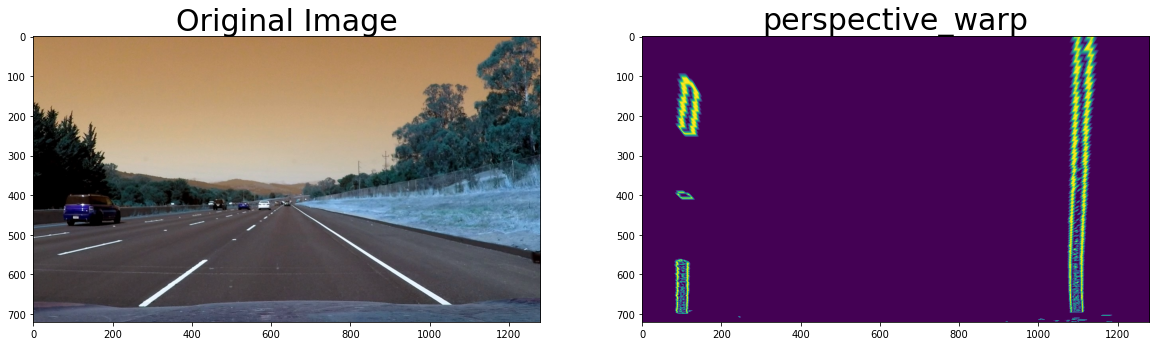

In [6]:
img = cv2.imread('test.jpg')
dst1 = perspective_warp(dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst1)
ax2.set_title('perspective_warp', fontsize=30)

In [7]:
def inv_perspective_warp(img):
    dst_size=(img.shape[1],img.shape[0])
    src=np.float32([(0,0), (1, 0), (0,1), (1,1)])
    dst=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)])
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

Text(0.5, 1.0, 'inv_perspective_warp')

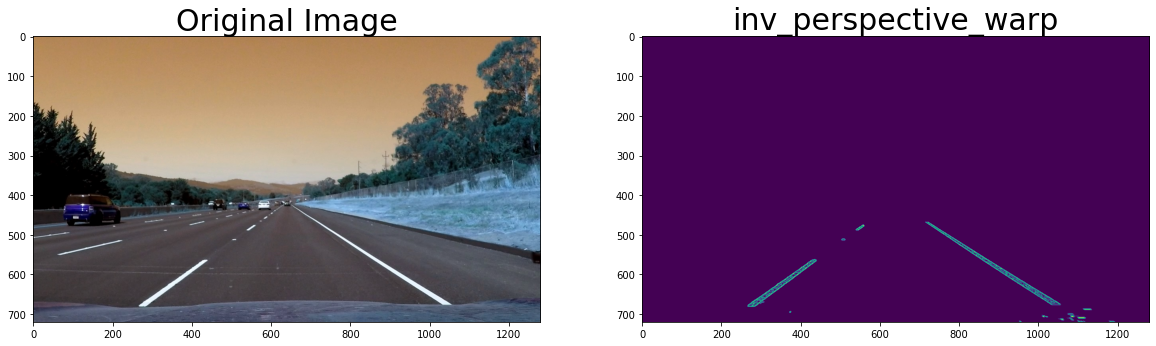

In [8]:
img = cv2.imread('test.jpg')
dst = inv_perspective_warp(dst1)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('inv_perspective_warp', fontsize=30)

In [9]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

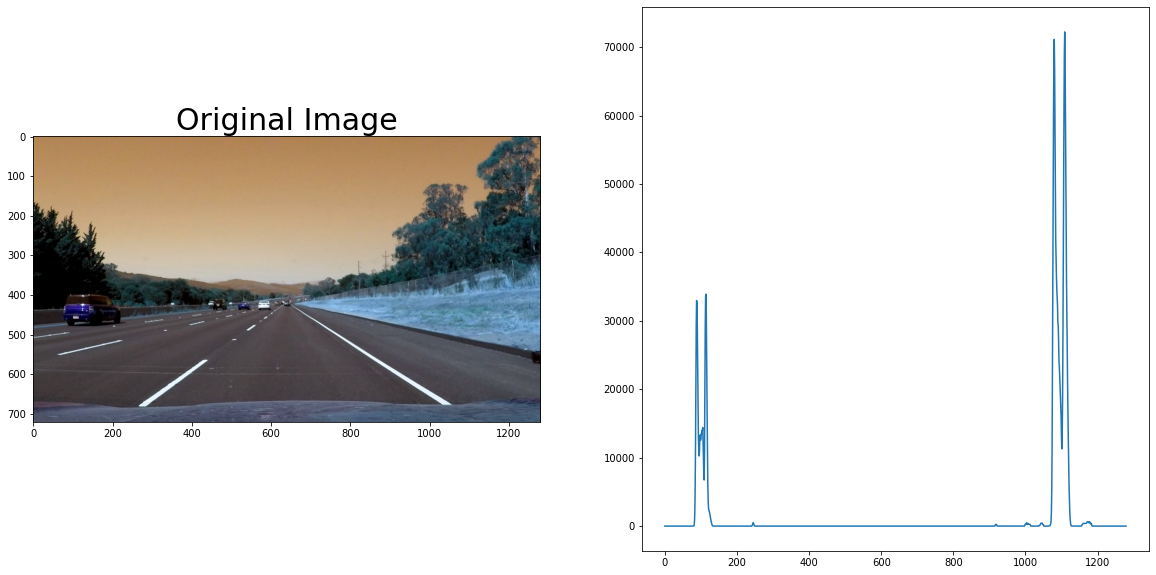

In [10]:
img = cv2.imread('test.jpg')
dst2 = get_hist(dst1)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
plt.plot(dst2)

In [11]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, nwindows=9, margin=150, minpix = 1, draw_windows=True):
    global left_a, left_b, left_c,right_a, right_b, right_c 
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    out_img = np.dstack((img, img, img))*255

    histogram = get_hist(img)
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (100,255,255), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (100,255,255), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
    
    return out_img, (left_fitx, right_fitx)


Text(0.5, 1.0, 'sliding_window')

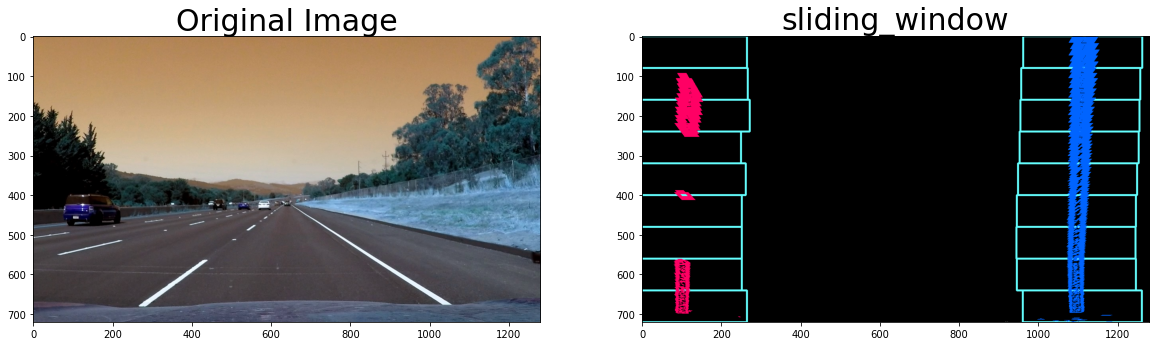

In [12]:
img = cv2.imread('test.jpg')
dst, (left_fitx, right_fitx) = sliding_window(dst1, 9, 150, 1, True)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('sliding_window', fontsize=30)

In [13]:
def get_curve(img, leftx, rightx):
    # Generate y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    # calculate meters per pixel (field of view in meters / image width)
    ym_per_pix = 30.5/720 # meters per pixel in y dimension 
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #calculate car position
    car_pos = img.shape[1]/2

    #calculate lane center 
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2

    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

In [14]:
def draw_lanes(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))
    
    cv2.fillPoly(color_img, np.int_(points), (0,200,255))
    inv_perspective = inv_perspective_warp(color_img)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective

In [15]:
debugging_mode=0
def vid_pipeline(img):
    edged = canny_edge_detector(img)
    warped = perspective_warp(edged)
    curves_image,curves= sliding_window(warped, draw_windows=False)
    curve_radius =get_curve(img, curves[0], curves[1])
    lane_curve = np.mean([curve_radius[0], curve_radius[1]])
    img = draw_lanes(img, curves[0], curves[1])
    
    font = cv2.FONT_HERSHEY_PLAIN
    fontColor = (255, 255, 255)
    fontSize=0.9

    cv2.putText(img, 'Radius of Curvature: {:.0f} m'.format(lane_curve), (30, 100), font, fontSize, fontColor, 2)
    if curve_radius[2] < 0:
       cv2.putText(img, 'Vehicle is {:.4f} m left of the center'.format(abs(curve_radius[2])), (30, 130), font, fontSize, fontColor, 2)
    else :
       cv2.putText(img, 'Vehicle is {:.4f} m right of the center'.format(abs(curve_radius[2])), (30, 130), font, fontSize, fontColor, 2)
    if debugging_mode:
    # add stages images to video
        edged=cv2.resize(edged,(200,200))
        edged = np.dstack((edged, edged, edged))*255
        x_offset=1080
        y_offset=0
        img[y_offset:y_offset+edged.shape[0], x_offset:x_offset+edged.shape[1]] = edged

        warped=cv2.resize(warped,(200,200))
        warped = np.dstack((warped, warped, warped))*255
        x_offset=1080
        y_offset=260
        img[y_offset:y_offset+warped.shape[0], x_offset:x_offset+warped.shape[1]] = warped

        curves_image=cv2.resize(curves_image,(200,200))
        x_offset=1080
        y_offset=520
        img[y_offset:y_offset+curves_image.shape[0], x_offset:x_offset+curves_image.shape[1]] = curves_image
    return img

[[255   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0 255 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [255   0   0 ...   0   0 255]]


Text(0.5, 1.0, 'vid_pipeline')

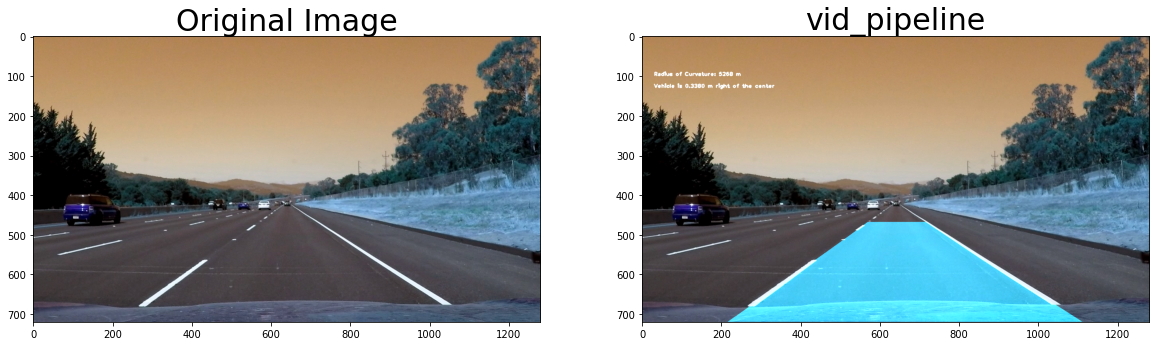

In [16]:
img = cv2.imread('test.jpg')
dst = vid_pipeline(img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('vid_pipeline', fontsize=30)

In [ ]:
debugging_mode=int(input('1 for debugging mode , 0 for normal mode'))
videos_list=os.listdir(os.getcwd()+'/test_videos')

for filename in videos_list:
    if filename.endswith(".mp4"):
        myclip=VideoFileClip(os.getcwd()+'/test_videos/'+str(filename)) # Change here
        output_vid = myclip.filename[:-4]+'_output.mp4'
        clip = myclip.fl_image(vid_pipeline)
        clip.write_videofile(output_vid, audio=False)